## Polygons_Extraction.ipynb

---

First, extracts the polygons from predicted segmentation masks (Run first predict.py) <br>
and then exports the polygons to a ESRI file (.shp)

Required Third-party libraries:
    
    * pandas
    * numpy

Alternative modules to visualize:
    
    * ipyleaflet

Required costum modules
    
    * ./functions/utils
    * ./functions/image
    * ./functions/load_data
    * ./functions/georeferencing_polygons
    
   
    * All satellite images are property of Google (Google, 2018)

In [1]:
%matplotlib inline

# //-------------------------------------------------------------\\

# Imports
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import multiprocessing as mp

# Custom modules
sys.path.append('../functions')
from georeferencing_polygons import PolygonsExtractor
from georeferencing_polygons import dissolve_polygons

from utils import files_paths
from load_data import DataGenerator
from image import read_image
from image import ImagePreprocessing
from image import display_overlap_images
from image import display_image_and_labels
from image import display_image_labels_and_prediction

np.random.seed(1234)

# //-------------------------------------------------------------\\

Using TensorFlow backend.


In [2]:
# Load images and predictions

# //-------------------------------------------------------------\\

# Input parameters

# Path where validation images are stored
validation_images_path = '../Data/Images/Validation_Images'
data_suffix = '_data.png'
labels_suffix = '_labels.png'

# Model date creation
weights_id = '2018-11-23_20_28_57'
prediction_suffix = '_prediction.png'

# Path where predictions are stored
predictions_path = '../Outputs/Validation_Images/predictions/'
predictions_path = os.path.join(predictions_path, weights_id)

# //-------------------------------------------------------------\\

validation_ims_paths = files_paths(validation_images_path, 
                                   nested_carpets=True, exts=data_suffix)
validation_labels_paths = [i.replace(data_suffix, 
                                     labels_suffix) for i in validation_ims_paths]

predictions_paths = [i.replace(validation_images_path, 
                               predictions_path) for i in validation_ims_paths]
predictions_paths = [i.replace(data_suffix, 
                               prediction_suffix) for i in predictions_paths]
    

print(f'Total number of images loaded : {len(validation_ims_paths)}')
print(f'Total number of labels loaded : {len(validation_labels_paths)}')
print(f'Total number of predictions loaded : {len(predictions_paths)}')

# //-------------------------------------------------------------\\

Total number of images loaded : 1600
Total number of labels loaded : 1600
Total number of predictions loaded : 1600


In [3]:
# Load the csv file with the reference center coordinate for each image

# //-------------------------------------------------------------\\

# Input parameters
images_info = '../Data/Images/Validation_Images/validation_images_info.csv'

# Columns names
center_lat = 'center_lat'
center_long = 'center_long'
image_filename = 'filename'

# //-------------------------------------------------------------\\

images_info = pd.read_csv(images_info)
images_info.head()

# //-------------------------------------------------------------\\

,center_long,center_lat,filename
0,-101.940320,19.376468,Image_2018-9-6_13_50_0_917097
1,-101.971228,19.375966,Image_2018-9-6_13_50_0_916923
2,-101.937942,19.376506,Image_2018-9-6_13_50_2_549084
3,-101.968850,19.376004,Image_2018-9-6_13_50_2_550574
4,-101.966473,19.376043,Image_2018-9-6_13_50_3_684410


In [5]:
# //-------------------------------------------------------------\\
def get_reference_coordinate(im_path):
    '''Helper function to retrieve the image center from csvfile'''
    global images_info    
    image_name = os.path.split(im_path.replace(prediction_suffix, data_suffix))[1]    
    mask = images_info.filename.apply(lambda x: re.findall(image_name, x))
    mask = mask.apply(lambda x: len(x) > 0)
    center = images_info[[center_long,center_lat]][mask].values[0]
    return center
# //-------------------------------------------------------------\\

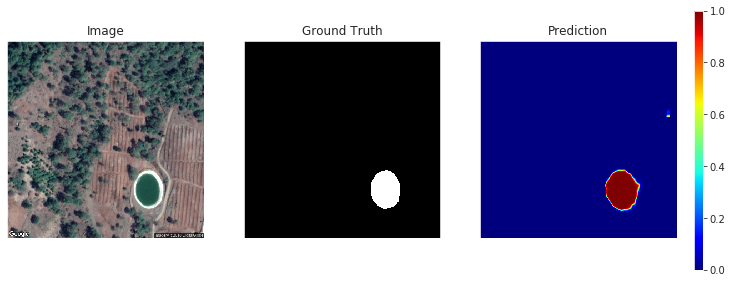

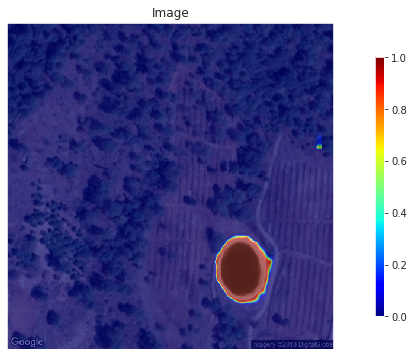

In [6]:
# Display one image

# //-------------------------------------------------------------\\

# Input parameters

index = 958

# Image pre-processing
im_prep_funcs = ['zero padding']
im_prep_params = {'pad_size':20}

# //-------------------------------------------------------------\\

# Fit an image pre-processing object
im_preprocessing = ImagePreprocessing(im_prep_funcs, im_prep_params)

im = read_image(validation_ims_paths[index])
labels = read_image(validation_labels_paths[index])
prediction = read_image(predictions_paths[index])
prediction = im_preprocessing(prediction)

display_image_labels_and_prediction(im, labels, prediction)
display_overlap_images(im, prediction)

# //-------------------------------------------------------------\\

In [7]:
# Fit the image generator

# //-------------------------------------------------------------\\

# Input parameters

batch_size = 1

# Image pre-processing
im_prep_funcs = ['zero padding', 'pick channels']
im_prep_params = {'pad_size': 20, 'idxs_channel': 0}

# //-------------------------------------------------------------\\

input_parameters = {'ims_paths' : predictions_paths,
                    'batch_size' : batch_size,
                    'im_prep_funcs' : im_prep_funcs,
                    'im_prep_params' : im_prep_params,}

images = DataGenerator(**input_parameters)
    
print('Dataset information:')
print(images)

# //-------------------------------------------------------------\\

Dataset information:

DataGenerator object 

Information:

      Number of samples : 1600
      Image height : 552
      Image width : 552
      Number of channels : 1
      Number of classes : None



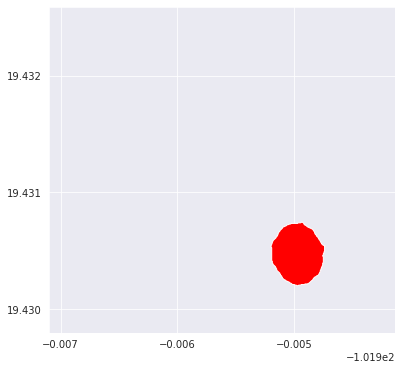

In [8]:
# Georeferencing and extracting the polygons in the image

# //-------------------------------------------------------------\\

# Input parameters

# Threshold decision
thr_decision = 0.95

# The PolygonExtractor class needs the referece image center in (long, lat) decimal format. 
# But it also needs a metric coordinate referece system to reproject the reference center. 
# See geopandas documentation:
# http://geopandas.org/
crs_rep = {'init': 'epsg:6372'}

# Zoom image; see google maps documentation:
# https://developers.google.com/maps/documentation/maps-static/intro
zoom = 18

# //-------------------------------------------------------------\\

# Get the image
im = images[index][0]
im_path = images.batch_ims_paths[0]

# Get the image center coordinate
center = get_reference_coordinate(im_path)

# Fit the extractor
input_parameters = {'im' : im,
                    'center' : center,
                    'crs_rep' : crs_rep,
                    'zoom' : zoom,
                    'thr_decision' : thr_decision}


with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Get the polygons
    p = PolygonsExtractor(**input_parameters)
    polygons = p.get_polygons()
    p.plot_polygons()    

# //-------------------------------------------------------------\\

In [10]:
# Extract the polygons in all images

# //-------------------------------------------------------------\\

# Input parameters
thr_decision = 0.95
crs_rep = {'init': 'epsg:6372'}
zoom = 18

# How many cores to use in multiprocessing
n_cores = 4

# //-------------------------------------------------------------\\

def extract_polygons(idx):

    # Get the image
    im = images[idx][0]
    im_path = images.batch_ims_paths[0]

    if idx > 0 and not idx % 100:
        print(f'Current idx : {idx}')

    # Get the reference center
    center = get_reference_coordinate(im_path)
    input_parameters = {'im' : im,
                        'center' : center,
                        'crs_rep' : crs_rep,
                        'zoom' : zoom,
                        'thr_decision' : thr_decision}
    
    # Fit the polygon extractor
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        p = PolygonsExtractor(**input_parameters)

        if idx == 0:
            print('\nGeographic reference information:')
            print(f'Pixel resolution X : {p.resolution_x:.6f}')
            print(f'Pixel resolution Y : {p.resolution_y:.6f}')
            print(f'Zoom image : {p.zoom}')
            print(f'CRS : {p.crs}')
            print(f'Threshold decision : {p.thr_decision}\n')

        # Get the polygons
        polygons = list(p.get_polygons().values())

    return polygons
    
    
# //-------------------------------------------------------------\\

# Extract the polygons
pool = mp.Pool(processes=n_cores)
polygons = pool.map(extract_polygons, range(len(images)))
pool.close()

# Remove empty lists
polygons = np.concatenate(polygons)

# //-------------------------------------------------------------\\

Current idx : 200

Geographic reference information:
Pixel resolution X : 0.561938
Pixel resolution Y : 0.558593
Zoom image : 18
CRS : {'init': 'epsg:6372'}
Threshold decision : 0.95

Current idx : 100
Current idx : 300
Current idx : 400
Current idx : 600
Current idx : 500
Current idx : 700
Current idx : 800
Current idx : 1000
Current idx : 900
Current idx : 1100
Current idx : 1200
Current idx : 1400
Current idx : 1300
Current idx : 1500


array([<shapely.geometry.polygon.Polygon object at 0x7fc6329fa190>,
      dtype=object)

In [12]:
# Dissolve the overlaped polygons and return them as a GeoDataFrame
dissolved = dissolve_polygons(polygons)
dissolved.shape

(529, 1)

In [13]:
# Export to an ESRI shapefile

# //-------------------------------------------------------------\\

# Input parameters

# Output_path to save de shapefile

# Create an output directory with the model ID
# to store the results

output_path = '../Outputs/Validation_Images/predicted_polygons'
if not os.path.exists(output_path):
    os.mkdir(output_path)


output_path = os.path.join(output_path, weights_id)
if not os.path.exists(output_path):
    os.mkdir(output_path)
output_path = os.path.join(output_path, 'polygons.shp')

# //-------------------------------------------------------------\\

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    dissolved = dissolved.to_crs(crs_rep)
    dissolved.to_file(driver='ESRI Shapefile', filename=output_path)

print(f'Saved file at : {output_path}')

# //-------------------------------------------------------------\\

Saved file at : ../Outputs/Validation_Images/predicted_polygons/2018-11-23_20_28_57/polygons.shp


In [21]:
# Polygons visualization

# //-------------------------------------------------------------\\

import shapely
from ipyleaflet import Polygon, Map, basemaps, basemap_to_tiles

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.iopub_data_rate_limit = 10000000000000

# //-------------------------------------------------------------\\

# Input parameters

date = '2020-01-00'
center = (19.40894, -101.92296)
zoom = 13

# //-------------------------------------------------------------\\

m = Map(layers=(basemap_to_tiles(basemaps.Esri.WorldImagery, date),),
        center=center, zoom=zoom)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    dissolved = dissolved.to_crs({'init': 'epsg:4326'})

for i in range(dissolved.shape[0]):
    if isinstance(dissolved.geometry.values[i], shapely.geometry.polygon.Polygon):
        x,y = dissolved.geometry.values[i].exterior.xy
        yx = np.column_stack((y,x))
        polygon = Polygon(locations=yx.tolist(), color='red',fill_color='red', fill=True, weight=1)
        m.add_layer(polygon)
    elif isinstance(dissolved.geometry.values[i], shapely.geometry.multipolygon.MultiPolygon):
        for j in range(len(dissolved.geometry.values[i])):
            x,y = dissolved.geometry.values[i][j].exterior.xy
            yx = np.column_stack((y,x))
            polygon = Polygon(locations=yx.tolist(), color='red',fill_color='red', fill=True, weight=1)
            m.add_layer(polygon)

# //-------------------------------------------------------------\\

In [22]:
m

Map(center=[19.40894, -101.92296], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…